# Twitter Sentiment Analysis
##### Jeremiah Geisterfer & Quincy Meisman

## Introduction:
In our project, we do sentiment analysis on a Twitter data set using SVM, random forest, and gradient boosting.

We start our project by exploring and describing the data. We then do preprocessing of the data to format it such that it can be used by the models. We do this by tokenizing the data using the options lemmatization and term frequency-inverse.

As a foundation we produce a baseline performance for each model, passing in the tokenized data with both lemmatization and term frequency-inverse on.

Next, we begin the selection process. First, we find the optimal number of samples to work with. We then use that sample size to find the optimal number of features. Finally, we use the optimal number of samples and features to find the best hyperparameters for each classifier.

Using the found sample size, features, and hyperparameters we run the classifiers with different formations of the data such as applying lemmatization but not term frequency inverse. We then present and discuss the results.


#### Data Description:
There are three features: Twitter ID, category, and the message text. Twitter ID is the account number of the person who made the post; the category is one of 32 topics the posts were made about, the majority of which are popular games and large companies; and the message text is the post itself.

In [15]:
import numpy as np
import pandas as pd
import matplotlib as plt
import random

In [213]:
#This cell was written by Quincy
def data_import_dirty(file):
    data = pd.read_csv(file, names=['id', 'company', 'sentiment', 'message'])
    return data.dropna()
#We downloaded the file on to our computers because a login was required to access the file
class Data:
    train_data = data_import_dirty('twitter_training.csv')
    valid_data = data_import_dirty('twitter_validation.csv')
    whole_data = pd.concat([train_data, valid_data])  #panda frame
    values = whole_data.values #list
    categories = np.unique(values[:,1])
    labels = np.unique(values[:,2])

    def print_sample(data):
        print(data.head())

    def print_pie_chart(array_of_percentages, array_of_labels, title):
        fig, ax = plt.subplots()
        ax.set_title(title);
        if len(array_of_labels) < 10:
            ax.pie(array_of_percentages, labels=array_of_labels, autopct='%.1f%%');
        else:
            ax.pie(array_of_percentages)
            ax.legend(Data.categories,title="Categories", loc='best', bbox_to_anchor=(1, 0, 0.5, 1))

    # The reason index is not hardcoded is because array_of_values isn't always in the same form
    def get_label_count(array_of_values, index):
        positive = np.sum(array_of_values[:,index] == 'Positive')
        negative = np.sum(array_of_values[:,index] == 'Negative')
        neutral = np.sum(array_of_values[:,index] == 'Neutral')
        irrelevant = np.sum(array_of_values[:,index] == 'Irrelevant')
        return [positive, negative, neutral, irrelevant]

    # array_of_values can be whatever slice of data you want as long as the company is in index 1
    def get_company_count(array_of_values):
        company_count = []
        for company in Data.categories:
            company_count.append(np.sum(array_of_values[:,1] == company))
        return company_count

    # Prints the percentage of labels for each category in pie chart form
    def print_labels_of_categories():
        list_of_labels_per_category = []
        for category in Data.categories:
            row_of_labels = []
            for row in Data.whole_data.values:
                #print(row)
                if row[1] == category:
                    row_of_labels.append(row[2])
            list_of_labels_per_category.append(row_of_labels)

        label_count = []
        for row_of_labels in list_of_labels_per_category:
            row_of_labels = np.array(row_of_labels)[np.newaxis].T    # I have to transpose this so that it works with get_label_count()
            #print(row_of_labels)
            label_count.append(Data.get_label_count(row_of_labels, 0))

        height,width = 8, 4
        fig, ax = plt.subplots(height,width, figsize=(15,10))
        fig.suptitle('Percentage of labels per category')
        for row in range(height):
            for col in range(width):
                index = row * (width) + col
                ax[row][col].set_title(Data.categories[index]);
                ax[row][col].pie(label_count[index]);
        #fig.legend()
        ax[0][0].legend(Data.labels,title="Labels", loc='center',bbox_to_anchor=(1, 0, 0.5, 1));

In [214]:
Data.print_sample(Data.valid_data)

     id    company   sentiment  \
0  3364   Facebook  Irrelevant   
1   352     Amazon     Neutral   
2  8312  Microsoft    Negative   
3  4371      CS-GO    Negative   
4  4433     Google     Neutral   

                                             message  
0  I mentioned on Facebook that I was struggling ...  
1  BBC News - Amazon boss Jeff Bezos rejects clai...  
2  @Microsoft Why do I pay for WORD when it funct...  
3  CSGO matchmaking is so full of closet hacking,...  
4  Now the President is slapping Americans in the...  


In [ ]:
label_count = Data.get_label_count(Data.whole_data.values, 2)
data = [
    [Data.labels[0], label_count[0]],
    [Data.labels[1], label_count[1]],
    [Data.labels[2], label_count[2]],
    [Data.labels[3], label_count[3]]
        ]
pd.DataFrame(data, columns = ['Label', 'Examples'])

,Label,Examples
0,Irrelevant,20932
1,Negative,22624
2,Neutral,18393
3,Positive,13047


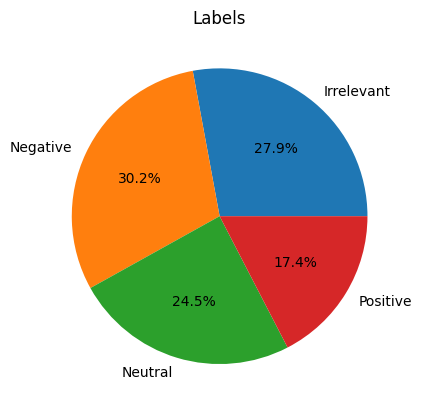

In [ ]:
Data.print_pie_chart(Data.get_label_count(Data.whole_data.values, 2), Data.labels, 'Labels')

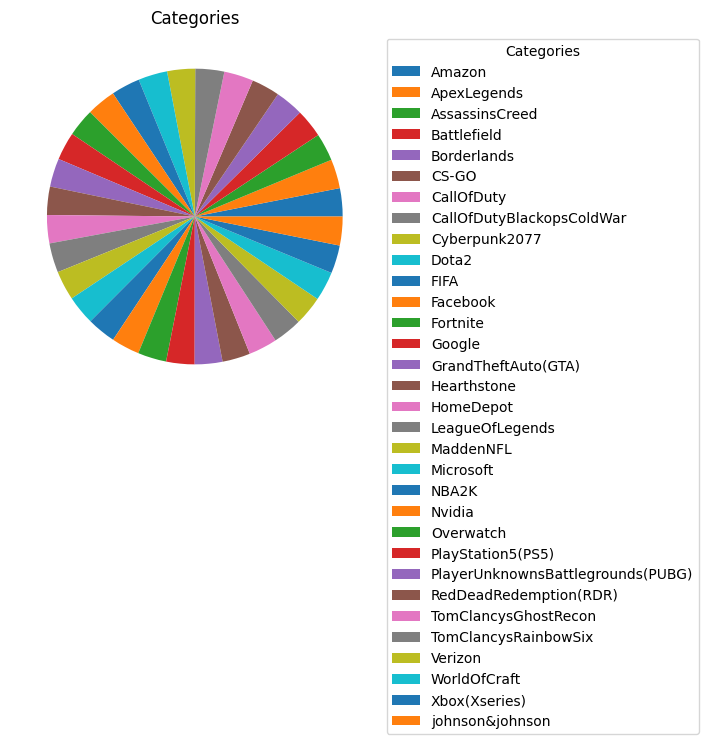

In [ ]:
Data.print_pie_chart(Data.get_company_count(Data.values), Data.categories, 'Categories')

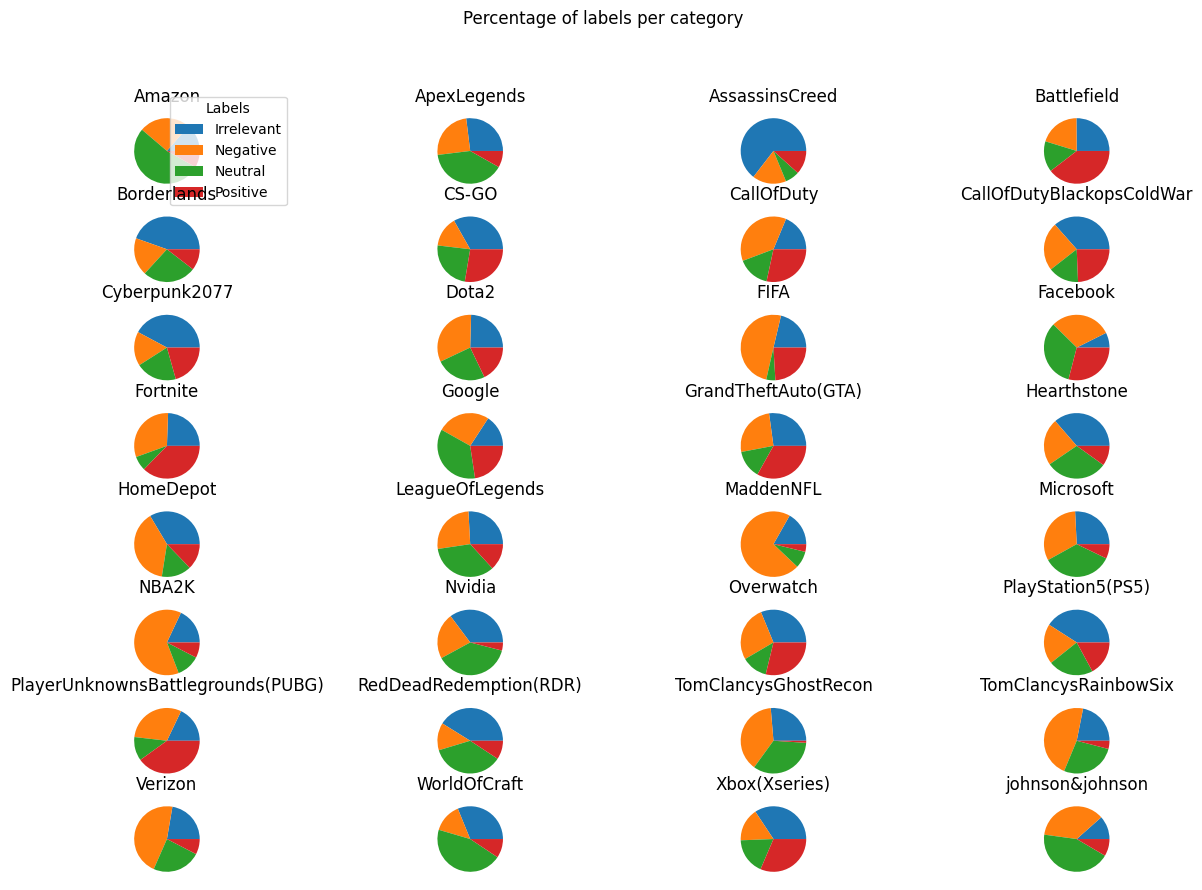

In [ ]:
Data.print_labels_of_categories()

### Data Formatting

To format the data so it can be used with SVM, random forest, and gradient boosting we tokenize it through our method data_import_sparse(file, lemma  = True, tfidf = True, company = True, tweetID = True). This method provides different options for tokenizing the data, the two most important being lemmatization and term-frequency times inverse document-frequency.


Lemmatization is the process of reducing words to their base form with consideration of their context. Taking into account context helps prevent reducing a word into a non-word by checking that the reduced word is a valid word. Lemmatization is powerful because reducing words to their base form can help the accuracy of a model and it significantly reduces the size of the tokenized data that will be passed to the machine learning models.


Term frequency times inverse document frequency essentially reduces the impact of frequently used words. This is done by shrinking the values in the vector (feature) for frequently used words. Frequently used words are often articles and prepositions that add little new information or meaning to a sentence, so it is helpful to reduce their impact.


We included the options for keeping the company and tweet ID out of curiosity if they can play any role. To represent the category information we used one hot encoding.

In [112]:

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt

In [2]:
# This cell writen by Jeremiah
# Used for creating the matrix for companies
def one_hot_encoding(data, labels):
    X = np.zeros((data.shape[0],labels.size))
    for i, labels in enumerate(labels):
        X[data[:,1]==labels,i] = 1
    return X

#https://scikit-learn.org/stable/modules/feature_extraction.html
#got from sklearn used for lemmatization
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

import scipy as sp
'''This is used to import the data. 
file = the file to be loaded. 
lemma = if you want LemmaTokenizer to be used when vectorizing data
tfidf = if you want to have tfidf transform the matrix after vectorization
company = if you want to have the 32 company one hot encoded matrix added to the data
tweetID = if you want to include the tweetID in the data
'''
def data_import_sparse(file, lemma  = True, tfidf = True, company = True, tweetID = True):
    data_df = data_import_dirty(file)
    data = data_df.values
    #print('Company:',company_names.shape)
    labels = np.unique(data[:,2])
    # print(labels)
    y = np.zeros((data.shape[0]), dtype=int)
    for i, sentiment in enumerate(labels):
        y[data[:,2] == sentiment] = i

    #print(X.shape)
    if lemma:
        word_transformer = CountVectorizer(tokenizer=LemmaTokenizer())
    else:
        word_transformer = CountVectorizer()

    word_transformer.fit(data[:,3])
    transformed = word_transformer.transform(data[:,3])

    if tfidf:
        tfidf = TfidfTransformer().fit(transformed)
        transformed = tfidf.transform(transformed)

    X = sp.sparse.csc_matrix(transformed)

    if company:
        company_names = np.unique(data[:,1])
        company_array = one_hot_encoding(data, company_names)
        X = sp.sparse.hstack((company_array, X))

    if tweetID:
        ID = np.vstack((data[:,0]))
        X = sp.sparse.hstack((ID, X))

    #print(newX.shape,transformed.shape)

    #print(transformed.shape)
    return X, y

In [7]:
X,y = data_import_sparse('twitter_training.csv', company=False, tweetID=False)

/Users/jcgeist/miniconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


### **Methodology**
The baseline accuracies for svm and random forest were good, and if we had changed the depth of gradient boosting it would have likely been comparable. Therefore the focus of improving these classifiers was on reducing the size of the vectorized data and reducing the runtime. The first step in this process was to cut down the number of samples we used to train. The next step was to reduce the number of features. We then used these optimal number of samples and features to find the optimal hyperparameters for each classifier.
Throughout sample, feature, and hyperparameter selection we prioritized speed over a slight increase in accuracy. We are using many tools in the SKlearn package including RFE, SVM, OneVsRest, CountVectorizer, Pipeline, GirdSearchCV, RandomForest, GradientBoosting, and Tfidf. We also use matplotlib, spicy, and numpy.  

#### Classifier Baselines:
We decided to use SVM, Random Forest, and Gradient Boosting Classifiers. For a baseline, we decided to test each of these classifiers with default classifier settings with no modifications to the sample size or feature size. We did this so we could see how a model would do with just analyzing the tweet and not the tweetID or company. Our thinking was that the tweetID and company would have a large impact on the model and confuse the sentiment analysis that we wanted to explore. We imported the data with company and tweetID set to False but had lemma and tfidf set to True. The SVM classifier was tested with both the ‘linear’ kernel and ‘rbf’ and found that ‘rbf’ performed better so it was selected. Standardization was tested as well with SVM, however, the StandardScaler that was used was not able to standardize the mean due to the sparse matrix. For these reasons, a SVM with a ‘rbf’ kernel and no standardization was selected. 

In [8]:
# This cell writen by Jeremiah
'''
This takes in train and test data and trains and tests with the given classifier. 
It returns runtime of training the model and score with the given test data 
'''
import time
def baseline_train_test(X_train, y_train, X_test, y_test, classifier):
    starttime = time.time()
    classifier.fit(X_train,y_train)
    endtime = time.time()
    score = classifier.score(X_test,y_test)
    run_time = endtime - starttime
    return [score, run_time]

In [9]:
# This cell writen by Jeremiah
'''
This runs the actual base line test over X,y with the number of iterations provided
X,y = data set 
iterations = number of train-test splits to test
'''
def run_classifier_baseline(X,y, iterations = 5):
    rf = RandomForestClassifier(n_jobs=8)
    svm_classifier = svm.SVC(kernel='rbf')
    ovr = OneVsRestClassifier(svm_classifier,n_jobs=4)
    gbc = GradientBoostingClassifier()
    rf_score = []
    ovr_score = []
    gbc_score = []
    for i in range(iterations):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, shuffle= True)
        rf_score.append(baseline_train_test(X_train,y_train,X_test,y_test, rf))
        ovr_score.append(baseline_train_test(X_train,y_train,X_test,y_test, ovr))
        gbc_score.append(baseline_train_test(X_train,y_train,X_test,y_test, gbc))

    return (rf_score,ovr_score,gbc_score)

In [10]:
rf_score, ovr_score, gbc_score = run_classifier_baseline(X,y)

In [11]:
data = [
    ['SVM', np.mean(np.array(ovr_score)[:,0]), np.min(np.array(ovr_score)[:,0]),np.max(np.array(ovr_score)[:,0]), np.min(np.array(ovr_score)[:,1])],
    ['Random Forest', np.mean(np.array(rf_score)[:,0]), np.min(np.array(rf_score)[:,0]),np.max(np.array(rf_score)[:,0]), np.min(np.array(rf_score)[:,1]) ],
    ['Gradient Boosting', np.mean(np.array(gbc_score)[:,0]), np.min(np.array(gbc_score)[:,0]),np.max(np.array(gbc_score)[:,0]), np.min(np.array(gbc_score)[:,1])],
        ]
pd.DataFrame(data, columns = ['Classifier', 'Avg Accuracy', 'Min Accuracy', 'Max Accuracy', 'Runtime(seconds)'])


,Classifier,Avg Accuracy,Min Accuracy,Max Accuracy,Runtime(seconds)
0,SVM,0.920456,0.917474,0.921798,919.838761
1,Random Forest,0.902221,0.899635,0.905176,14.638035
2,Gradient Boosting,0.552061,0.547682,0.554890,506.990981


##### Discussion of Baseline Performance

* SVM: the baseline accuracy was the best with a 92%, but it was by far the longest runtime.
* Random Forrest: the baseline accuracy was 2% less than SVM but with a runtime 65x faster than SVM it is definitely the better model, and best of the three models.
* Gradient Boosting: the baseline performance of gradient boosting was by far the worst. We attribute this to the default parameter of max_depth being set to 3.


#### Sample Selection:
In this section we will reduce the number of samples that are used to train a classifier and observer the affect on accuracy. We will create a learning curve from the predictions from different test splits given different sample sizes. We will select a number of samples to use moving forward based on the information gained in this section. 


In [10]:
'''
This was provided by Asa in assignment3_solution.ipynb
'''
def train_test_valid_split(X, y, f_train, f_valid, f_test, shuffle = False) :
    X_tv, X_test, y_tv, y_test = train_test_split(X, y, test_size = f_test, shuffle=shuffle)
    X_train, X_valid, y_train, y_valid = train_test_split(
        X_tv, y_tv, test_size = f_valid / (f_train + f_valid), shuffle=shuffle)
    return X_train, y_train, X_valid, y_valid, X_test, y_test

In [29]:
# This cell writen by Jeremiah
'''
num_splits = number of different sample sizes to run
This takes in a set of train and test data and a classifier and trains the model on a subset of the whole data
'''
def sample_selector(X_train,y_train,X_test,y_test, classifier, num_splits = 10, shuffle = True):
    split_size = 100/num_splits/100
    acc = []
    train_size = []
    for i in range(num_splits):
        test_size = i*split_size
        if test_size == 0: 
            test_size = 1
        X_train_new, _, y_train_new, _ = train_test_split(X_train, y_train, test_size = test_size, shuffle=shuffle, random_state=i)
        classifier.fit(X_train_new,y_train_new)
        acc.append(classifier.score(X_test,y_test))
        train_size.append(X_train_new.shape[0])
    return acc, train_size

In [30]:
# This cell writen by Jeremiah
'''
This is the function used to actually run the sample selection experiment
num_runs = numbers of times to run the sample selector
num_splits = numbers of splits over the full number of samples
'''
def do_sample_exp(X,y, num_runs = 3, num_splits = 10):
    RF_acc = []
    SVM_acc = []
    GB_acc = []
    for i in range(num_runs):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, shuffle= True, random_state=i)
        accRF, xlabel = sample_selector(X_train, y_train, X_test, y_test, RandomForestClassifier(n_estimators=100,n_jobs=8), num_splits= num_splits)
        accSVM, _ = sample_selector(X_train, y_train, X_test, y_test, OneVsRestClassifier(svm.SVC(kernel = 'rbf')), num_splits= num_splits)
        accGB, _ = sample_selector(X_train, y_train, X_test, y_test, GradientBoostingClassifier(), num_splits= num_splits)
        RF_acc.append(accRF)
        SVM_acc.append(accSVM)
        GB_acc.append(accGB)
    return RF_acc,SVM_acc,GB_acc,xlabel


This train_test_split will be used as the main training set and a validation set for each experiment. Each experiment further train_test_split's the data during the expreiment. 

In [45]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = .15, shuffle= True)

In [46]:
accRF, accSVM, accGB, xlabel = do_sample_exp(X_train,y_train)

##### Testing max_depth for Gradient Boosting Classifier:
After reviewing the original learning curve, Gradient Boosting appears to be limited by the max depth, because of this a simple test is needed to determine the correct max depth for this feature set. Once a proper depth is determined the Gradient Boosting sample selection will be re-run. 

In [50]:

X_train_gb, X_test_gb, y_train_gb, y_test_gb = train_test_split(X, y, test_size = .30, shuffle= True)
max_depth_list = [3,4,6,10,15,20,30]
gb_acc = []
for i in max_depth_list:
    gb_classifier = GradientBoostingClassifier(max_depth=i).fit(X_train_gb,y_train_gb)
    gb_acc.append(gb_classifier.score(X_test_gb,y_test_gb))


In [57]:
data = data = [
    ['3', gb_acc[0]],
    ['4', gb_acc[1]],
    ['6', gb_acc[2]],
    ['10', gb_acc[3]],
    ['15', gb_acc[4]],
    ['20', gb_acc[5]],
    ['30', gb_acc[6]],
    ['50', gb_acc[7]]
        ]
pd.DataFrame(data, columns = ['Depth', 'Accuracy'])

,Depth,Accuracy
0,3,0.549439
1,4,0.575116
2,6,0.617640
3,10,0.695842
4,15,0.758728
5,20,0.799901
6,30,0.839632
7,50,0.860399


##### Response to max_depth:
Training times rise quickly with the increase of depth. Due to this a max_depth of 30 was selected. It provided an 84% accuracy compared to a depth of 50, where an accuracy of 86% was achecived. Since the tree almost doubled in size from 30 to 50 with only a change of 2% in accuracy, 30 was selected. 

In [59]:
best_depth = 30
newGB, label = sample_selector(X_train_gb, y_train_gb, X_test_gb, y_test_gb, GradientBoostingClassifier(max_depth=best_depth), num_splits= 10)

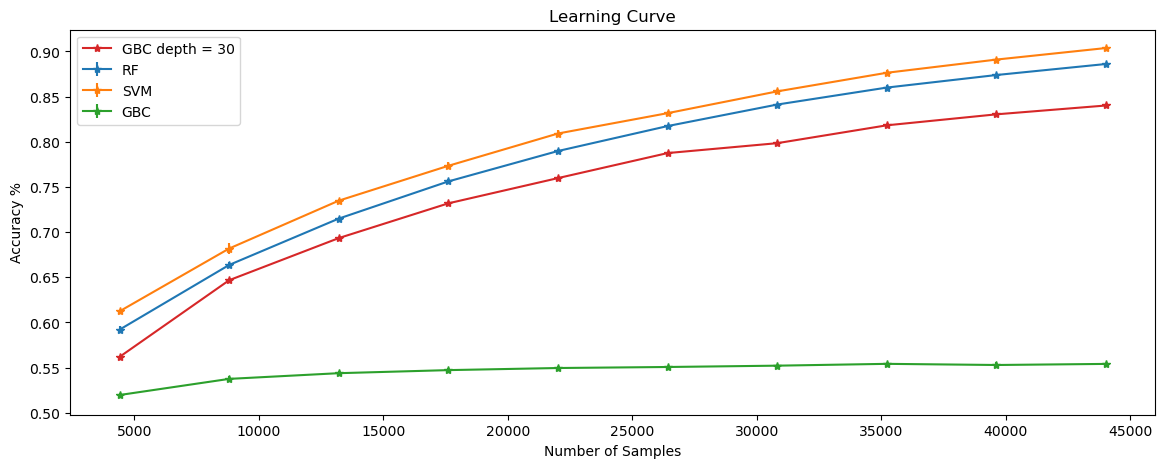

In [61]:
plt.figure(figsize=(14, 5))
plt.errorbar(xlabel, np.mean(np.array(accRF), axis = 0), yerr= np.std(np.array(accRF), axis = 0),label = 'RF', marker = "*")
plt.errorbar(xlabel, np.mean(np.array(accSVM), axis = 0), yerr= np.std(np.array(accSVM), axis=0), label = 'SVM', marker = "*")
plt.errorbar(xlabel, np.mean(np.array(accGB), axis = 0), yerr= np.std(np.array(accGB), axis = 0), label = 'GBC', marker = "*")
plt.plot(xlabel, newGB, label = 'GBC depth = 30', marker = '*')
plt.title("Learning Curve")
plt.xlabel("Number of Samples")
plt.ylabel("Accuracy %")
plt.legend(loc = 'best');

In [68]:
number_of_samples_RF = 40000
number_of_samples_SVM = 40000
number_of_samples_GB = 40000

In [71]:
#Here we take the train set and further reduce the number of samples that it contains to the selected number of samples. 
X_train_rf, _, y_train_rf, _ = train_test_split(X_train, y_train, test_size = X_train.shape[0]-number_of_samples_RF, shuffle=True, random_state=1)
X_train_svm, _, y_train_svm, _ = train_test_split(X_train, y_train, test_size = X_train.shape[0]-number_of_samples_SVM, shuffle=True, random_state=1)
X_train_gbc, _, y_train_gbc, _ = train_test_split(X_train, y_train, test_size = X_train.shape[0]-number_of_samples_GB, shuffle=True, random_state=1)

In [99]:
rf = RandomForestClassifier().fit(X_train_rf,y_train_rf)
rf_valid_score = rf.score(X_valid,y_valid)

In [100]:
svm = OneVsRestClassifier(svm.SVC(kernel = 'rbf')).fit(X_train_svm,y_train_svm)
svm_valid_score = svm.score(X_valid,y_valid)

In [101]:
gbc = GradientBoostingClassifier(max_depth=30).fit(X_train_gbc,y_train_gbc)
gbc_valid_score = gbc.score(X_valid,y_valid)

##### Sample Selection Validation Results:
Below are the results from each classifier on the validation data using the number of selected samples of 40,000. 

In [102]:
data = data = [
    ['SVM', svm_valid_score],
    ['Random Forest',  rf_valid_score],
    ['Gradient Boosting', gbc_valid_score],
        ]
pd.DataFrame(data, columns = ['Classifier', 'Accuracy'])

,Classifier,Accuracy
0,SVM,0.890991
1,Random Forest,0.872432
2,Gradient Boosting,0.810631


##### Sample Selection Response:
The generated learning curve shows that there is a general increase in accuracy as we increase the number of training samples. Since one of the goals is to reduce training times we will try to select a sample size that maintains a high accuracy while reducing the training size substantially. Based on the learning curve for each classifier a shared sample size of 40,000 was selected. This degraded the overall accuracy of each classifier by a maximum of a few percentage points. You can see from the graph that there are two curves for the GradientBoosting classifier. The green GB curve shows the first generated curve with the default depth of 3. This is not what we were expecting and decided to do a deeper dive into GB and found that max depth does affect accuracy heavily as well as run times. It appears that as more layers are added to the tree accuracy increases. We decided that with an Accuracy of 84% at depth 30 was close enough to the accuracy at depth 50 that it was worth the train time to select the lower depth. 

### Feature Selection:

In this section, we will attempt to further reduce the data set size by selectively reducing features. GridSearchCV and RFE are used with each of the classifiers. Since this is not a binary classification problem, the OneVsRestClassifier must be used with SVM. OneVsRestClassifier does not return the necessary feature contributions required for RFE to function properly. For this reason, we decided to provide a RandomForestClassifier to the RFE that does the feature selection for SVM. In an attempt to avoid having to use different classifiers for selection, we attempted to use PCA on the data set and use that as a way to reduce dimensionality. When trying to execute a mini experiment using PCA we learned PCA does not work on a sparse matrix and had to abandon the idea.  Once the feature selection is finished, the classifier is trained on the transformed data. This is done over 5 splits ranging from full feature selection to partial generating, a feature selection curve. 

In [69]:
# This cell writen by Jeremiah
'''
Used to create an array used for the feature_selector. 
It takes in X and num_splits
returns a list of ints that corresponds to the number of features to be selected at each split
'''
def feature_spliter(X, num_splits):
    num_features = int((X.shape[1]-100)/num_splits)
    feature_split = np.flip([i for i in range(X.shape[1], 0, -num_features)])
    return feature_split

In [70]:
# This cell writen by Jeremiah
'''
Does not work directly with SVM. RF used as a selector for SVM since SVM is wrapped by OVR
This runs a grid search over the number of slected features with the given selector and classifier. 
X,y = dataset 
classifier = classifier to test on
selector = expects an RSE
num_splits = number of splits over the max features
cv = either a CV object or an int with the number of folds
'''
def feature_selector(X,y, classifier, selector, num_splits = 10, cv = 3):
    feature_split = feature_spliter(X,num_splits)
    param_grid= {'feature_selector__n_features_to_select' : feature_split}
    pipeline = Pipeline([('feature_selector', selector),('classifier', classifier)])
    grid_search = GridSearchCV(pipeline, param_grid, refit=True, n_jobs=8, cv=cv, error_score='raise')
    grid_search.fit(X,y)
    return grid_search

In [72]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=3, random_state=1, shuffle=True)
splits = 5

In [73]:
resultsRF = feature_selector(X_train_rf,y_train_rf, 
                            RandomForestClassifier(n_estimators=100), RFE(RandomForestClassifier(n_estimators=100), step=.1),
                            num_splits= splits, cv = cv)

In [76]:
resultsSVM = feature_selector(X_train_svm,y_train_svm, 
                            OneVsRestClassifier(svm.SVC(kernel = 'rbf')), RFE(RandomForestClassifier(n_estimators=100), step=.1),
                            num_splits= splits, cv = cv)

In [77]:
resultsGB = feature_selector(X_train_gbc,y_train_gbc, 
                            GradientBoostingClassifier(max_depth=30), RFE(GradientBoostingClassifier(max_depth=30), step=.1),
                            num_splits= splits, cv = cv)

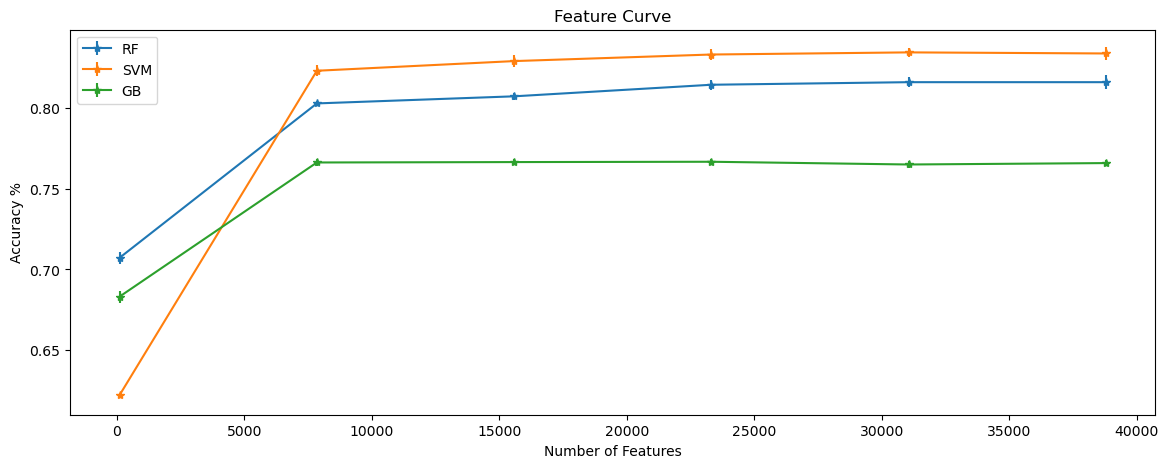

In [78]:
featuresRF = np.array(resultsRF.cv_results_['param_feature_selector__n_features_to_select'])
accuracyRF = np.array(resultsRF.cv_results_['mean_test_score'])
stdRF = np.array(resultsRF.cv_results_['std_test_score'])
featuresSVM = np.array(resultsSVM.cv_results_['param_feature_selector__n_features_to_select'])
accuracySVM = np.array(resultsSVM.cv_results_['mean_test_score'])
stdSVM = np.array(resultsSVM.cv_results_['std_test_score'])
featuresGB = np.array(resultsGB.cv_results_['param_feature_selector__n_features_to_select'])
accuracyGB = np.array(resultsGB.cv_results_['mean_test_score'])
stdGB = np.array(resultsGB.cv_results_['std_test_score'])
plt.figure(figsize=(14, 5))
plt.errorbar(featuresRF, accuracyRF, yerr=stdRF, label = 'RF', marker = "*")
plt.errorbar(featuresSVM, accuracySVM, yerr= stdSVM, label = 'SVM', marker = "*")
plt.errorbar(featuresGB, accuracyGB, yerr= stdGB, label = 'GB', marker = "*")
plt.title("Feature Curve")
plt.xlabel("Number of Features")
plt.ylabel("Accuracy %")
plt.legend(loc = 'best')

In [ ]:
data = data = [
    ['SVM', accuracySVM],
    ['Random Forest',  accuracyRF],
    ['Gradient Boosting', accuracyGB],
        ]
pd.DataFrame(data, columns = featuresRF)

In [81]:
SVM_num_feat = 7840
GB_num_feat = 7840
RF_num_feat = 7840

In [82]:
rf_rfe = RFE(RandomForestClassifier(), n_features_to_select=RF_num_feat, step=.1).fit(X_train_rf,y_train_rf)
X_rf_train_trans = rf_rfe.transform(X_train_rf)
X_rf_valid_trans = rf_rfe.transform(X_valid)
svm_rfe = RFE(RandomForestClassifier(), n_features_to_select=SVM_num_feat, step=.1).fit(X_train_svm,y_train_svm)
X_svm_train_trans = svm_rfe.transform(X_train_svm)
X_svm_valid_trans = svm_rfe.transform(X_valid)
gb_rfe = RFE(GradientBoostingClassifier(max_depth=30), n_features_to_select=GB_num_feat, step=.1).fit(X_train_gbc,y_train_gbc)
X_gb_train_trans = gb_rfe.transform(X_train_gbc)
X_gb_valid_trans = gb_rfe.transform(X_valid)

In [103]:
rf_feat = RandomForestClassifier().fit(X_rf_train_trans,y_train_rf)
rf_valid_score_feat = rf_feat.score(X_rf_valid_trans,y_valid)

In [113]:
classifier_svm = svm.SVC(kernel = 'rbf')
svm_feat = OneVsRestClassifier(classifier_svm).fit(X_svm_train_trans,y_train_svm)
svm_valid_score_feat = svm_feat.score(X_svm_valid_trans,y_valid)

In [114]:
gb_feat = GradientBoostingClassifier(max_depth=30).fit(X_gb_train_trans,y_train_gbc)
gb_valid_score_feat = gb_feat.score(X_gb_valid_trans,y_valid)

##### Feature Selection Validation Results:
Here are the validation results from training on the data set with 40,000 samples and 7840 features and testing on the validation data. 

In [115]:
data = data = [
    ['SVM', svm_valid_score_feat],
    ['Random Forest',  rf_valid_score_feat],
    ['Gradient Boosting', gb_valid_score_feat],
        ]
pd.DataFrame(data, columns = ['Classifier', 'Accuracy'])

,Classifier,Accuracy
0,SVM,0.879459
1,Random Forest,0.857928
2,Gradient Boosting,0.812883


##### Feature Selection Response:
Based on the graph above we have determined that 7840 features are all that is needed for each classifier to achieve accuracy comparable to the accuracy seen in the sample selection. For SVM and Random Forest Classifier, we lost around 2% accuracy compared to using the full set of features, this was an acceptable loss because we were able to reduce the overall number of features by about 5 times. Gradient Boosting however was able to acheive the same Accuracy. We are thinking this is due to max depth being set to 30, that the tree has been built and there are remaing features that are not used in building that tree. If we had more time, we would have liked to further explore features and try to continue to fine tune, but due to run times we were unable to run this experiment multiple times. 

### Hyperparamater Search: 
Now we will try to improve accuracy of our classifiers by trying to identify ideal hyperparamaters for each classifier. This will be done with GridSearchCV and StratifiedKFold

In [83]:
# This cell writen by Jeremiah
'''
Performs a grid search of paramaters on a classifier
X,y = dataset
pipeline = pipeline or classifier
param_grid = dictionary of paramaters to be tested
cv = cv or int with number of folds
n_jobs = number of jobs to run at one time
'''
def hyperparamater_search(X,y, pipeline, param_grid, cv = cv, n_jobs = 8):
    grid_search = GridSearchCV(pipeline, param_grid, refit = True, n_jobs = n_jobs, cv = cv, error_score='raise')
    grid_search.fit(X,y)
    return grid_search

##### Random Forest:

In [85]:
param_grid_rf = {'n_estimators': [10, 100, 500],
                 'min_samples_split': [2, 4, 8, 10],
                 'max_depth': [3,30,None]}
results_rf = hyperparamater_search(X_rf_train_trans, y_train_rf, RandomForestClassifier(), param_grid_rf, cv = cv)

/Users/jcgeist/miniconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [157]:
frame = pd.DataFrame.from_dict(results_rf.best_params_, orient='index')
frame = frame.style.hide(axis = 1)\
    .set_caption("Random Forest Best Params")\
    .format(precision=0)
display(frame)
print('Best Score:', results_rf.best_score_)

max_depth,nan
min_samples_split,2
n_estimators,500


Best Score: 0.8101999403892401


##### SVM

In [92]:
param_grid_svm = {'estimator__kernel' : ['rbf'],
                'estimator__C' : [.01, 1, 100, 1000],
                'estimator__gamma' : [0.01, 1, 100, 1000]}
classifier = svm.SVC()
results_SVM = hyperparamater_search(X_svm_train_trans, y_train_svm, OneVsRestClassifier(classifier), param_grid_svm, cv=cv)

In [158]:
frame = pd.DataFrame.from_dict(results_SVM.best_params_, orient='index')
frame = frame.style.hide(axis = 1)\
    .set_caption("SVM Best Params")\
    .format(precision=0)
display(frame)
print('Best Score:', results_SVM.best_score_)

estimator__C,100
estimator__gamma,1
estimator__kernel,rbf


Best Score: 0.8738251098395354


In [125]:
param_grid_svm_ = {'estimator__kernel' : ['rbf'],
                'estimator__C' : [10, 25, 40],
                'estimator__gamma' : [1]}
classifier = svm.SVC()
results_SVM_ = hyperparamater_search(X_svm_train_trans, y_train_svm, OneVsRestClassifier(classifier), param_grid_svm_, cv=cv)

In [159]:
frame = pd.DataFrame.from_dict(results_SVM_.best_params_, orient='index')
frame = frame.style.hide(axis = 1)\
    .set_caption("SVM Final Best Params")\
    .format(precision=0)
display(frame)
print('Best Score:', results_SVM_.best_score_)

estimator__C,25
estimator__gamma,1
estimator__kernel,rbf


Best Score: 0.8762000979678009


##### Gradient Boosting:

In [93]:
param_grid_gb = {'n_estimators': [10, 50, 100, 200],
                 'learning_rate': [.01, .1, .4, .8],
                 'max_depth': [30]}
results_gb = hyperparamater_search(X_gb_train_trans, y_train_gbc, GradientBoostingClassifier(), param_grid_gb, cv = cv)

In [160]:
frame = pd.DataFrame.from_dict(results_gb.best_params_, orient='index')
frame = frame.style.hide(axis = 1)\
    .set_caption("Gradient Boosting Best Params")\
    .format(precision=1)
display(frame)
print('Best Score:', results_gb.best_score_)

learning_rate,0.4
max_depth,30.0
n_estimators,100.0


Best Score: 0.7947500472422564


#### Hyperparamater Response:
For each of the classifiers, we tested a series of different hyperparameters on each using a GridSearchCV. 

Random Forest was the most unhelpful. Since the classifier is so good out of the box we did not see much gain except for with the number of estimators. Since accuracy didn't increase by a statistically relevant amount from 100 to 500 number of estimators the default 100 was selected. 

SVM went through several searches before landing on our final GridSearchCV. We found that a C value of 25 was optimal with a gamma of 1.  When using a OneVsRest and SVM with a GridSearchCV at first was a challenge to get working, the GridSearchCV returned that the OVR did not contain the parameters that were set in the param_grid. We then learned that to access the SVM inside the OVR we needed to include estimator__ in the param_grid key name for all SVM hyperparameters. With this figured out a grid search was possible. 

GradientBoosting classifier had ideal hyperparameters of 100 estimators and a learing rate of 0.4, we did not select a different depth due to run time and the baseline test that tested max_depth. We did see that as we increased the number of estimators the learning rate would also increase and not always produce a better accuracy with higher estimators. In another hyperparameter test, 200 estimators were tested and provided the best accuracy when the learning rate was set to .8. This is compared to an optimal learning rate of .4 with estimators set to 100.

### Running Models
Using the found optimal number of samples, optimal features, and optimal hyperparameters we run each of our models 6 times using different versions of the data. These different versions of the data are created through choosing relevent different combinations of parameters from our function data_import_sparse(). The combinations are as such:

lemma = False, tfidf = False, company = False, tweetID = False
* To create a new baseline relevant to the samples, features and hyperparameters we're now working with

lemma = True, tfidf = False, company = False, tweetID = False
* To see the impact just lemmatization has

lemma = False, tfidf = True, company = False, tweetID = False
* To see the impact just applying term frequency inverse has

lemma = True, tfidf = True, company = False, tweetID = False
* To see the combined effect of lemmatization and term frequency inverse has

lemma = True, tfidf = True, company = True, tweetID = False
* To see if accounting for the company has any effect

lemma = True, tfidf = True, company = True, tweetID = True
* To see if accounting for the tweetID has any effect


In [183]:
# Set the samples, features and hyperparameters based off the optimal values we found
# Random forest
num_samples_rf = 40000
num_features_rf = 7840
n_estimators_rf = 100
max_depth_rf = None

# Gradient boosting
num_samples_gb = 40000
num_features_gb = 7840
n_estimators_gb = 100
learning_rate = .4
max_depth_gb = 30

# SVM
num_samples_svm = 40000
num_features_svm = 7840
kernel = 'rbf'
C = 25
gamma = 1

In [164]:
# Create all the different data sets needed
X_all_false, y_all_false = data_import_sparse('twitter_training.csv', lemma  = False, tfidf = False, company = False, tweetID = False)
X_all_false_train, X_all_false_valid, y_all_false_train, y_all_false_valid = train_test_split(X_all_false,y_all_false, test_size=.15, shuffle = True, random_state=3)

X_lemma_true, y_lemma_true = data_import_sparse('twitter_training.csv', lemma  = True, tfidf = False, company = False, tweetID = False)
X_lemma_true_train, X_lemma_true_valid, y_lemma_true_train, y_lemma_true_valid = train_test_split(X_lemma_true,y_lemma_true, test_size=.15, shuffle = True, random_state=3)


X_tfidf_true, y_tfidf_true =  data_import_sparse('twitter_training.csv', lemma  = False, tfidf = True, company = False, tweetID = False)
X_tfidf_true_train, X_tfidf_true_valid, y_tfidf_true_train, y_tfidf_true_valid = train_test_split(X_tfidf_true,y_tfidf_true, test_size=.15, shuffle = True, random_state=3)

X_both_true, y_both_true =  data_import_sparse('twitter_training.csv', lemma  = True, tfidf = True, company = False, tweetID = False)
X_both_true_train, X_both_true_valid, y_both_true_train, y_both_true_valid = train_test_split(X_both_true,y_both_true, test_size=.15, shuffle = True, random_state=3)

X_company_true, y_company_true = data_import_sparse('twitter_training.csv', lemma  = True, tfidf = True, company = True, tweetID = False)
X_company_true_train, X_company_true_valid, y_company_true_train, y_company_true_valid = train_test_split(X_company_true,y_company_true, test_size=.15, shuffle = True, random_state=3)

X_tweetId_true, y_tweetId_true = data_import_sparse('twitter_training.csv', lemma  = True, tfidf = True, company = False, tweetID = True)
X_tweetId_true_train, X_tweetId_true_valid, y_tweetId_true_train, y_tweetId_true_valid = train_test_split(X_tweetId_true,y_tweetId_true, test_size=.15, shuffle = True, random_state=3)


/Users/jcgeist/miniconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/jcgeist/miniconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/jcgeist/miniconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/jcgeist/miniconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [184]:
svm_rf_rfe = RFE(RandomForestClassifier(n_jobs=8), n_features_to_select=num_features_rf, step=.1)
gb_rfe = RFE(GradientBoostingClassifier(max_depth=30), n_features_to_select=num_features_gb, step=.1)

In [166]:
X_all_false_rf_svm = svm_rf_rfe.fit_transform(X_all_false_train,y_all_false_train)
X_all_false_valid_rf_svm = svm_rf_rfe.transform(X_all_false_valid)
X_all_false_gb = gb_rfe.fit_transform(X_all_false_train,y_all_false_train)
X_all_false_valid_gb = gb_rfe.transform(X_all_false_valid)

In [181]:
X_lemma_true_rf_svm = svm_rf_rfe.fit_transform(X_lemma_true_train,y_lemma_true_train)
X_lemma_true_valid_rf_svm = svm_rf_rfe.transform(X_lemma_true_valid)
X_lemma_true_gb = gb_rfe.fit_transform(X_lemma_true_train,y_lemma_true_train)
X_lemma_true_valid_gb = gb_rfe.transform(X_lemma_true_valid)

In [193]:
X_tfidf_true_rf_svm = svm_rf_rfe.fit_transform(X_tfidf_true_train,y_tfidf_true_train)
X_tfidf_true_valid_rf_svm = svm_rf_rfe.transform(X_tfidf_true_valid)
X_tfidf_true_gb = gb_rfe.fit_transform(X_tfidf_true_train,y_tfidf_true_train)
X_tfidf_true_valid_gb = gb_rfe.transform(X_tfidf_true_valid)

In [187]:
X_both_true_rf_svm = svm_rf_rfe.fit_transform(X_both_true_train,y_both_true_train)
X_both_true_valid_rf_svm = svm_rf_rfe.transform(X_both_true_valid)
X_both_true_gb = gb_rfe.fit_transform(X_both_true_train,y_both_true_train)
X_both_true_valid_gb = gb_rfe.transform(X_both_true_valid)

In [188]:
X_company_true_rf_svm = svm_rf_rfe.fit_transform(X_company_true_train,y_company_true_train)
X_company_true_valid_rf_svm = svm_rf_rfe.transform(X_company_true_valid)
X_company_true_gb = gb_rfe.fit_transform(X_company_true_train,y_company_true_train)
X_company_true_valid_gb = gb_rfe.transform(X_company_true_valid)

In [195]:
X_tweetId_true_rf_svm = svm_rf_rfe.fit_transform(X_tweetId_true_train,y_tweetId_true_train)
X_tweetId_true_valid_rf_svm = svm_rf_rfe.transform(X_tweetId_true_valid)
X_tweetId_true_gb = gb_rfe.fit_transform(X_tweetId_true_train,y_tweetId_true_train)
X_tweetId_true_valid_gb = gb_rfe.transform(X_tweetId_true_valid)

In [185]:
# This cell writen by Quincy - Modified by Jeremiah
import time
def run_rf_or_svm(X_train, y_train, X_test, y_test, classifier, num_runs = 3):
    score = []
    run_time = []
    for i in range(num_runs):
      X_train_splice, _, y_train_splice, _ = train_test_split(X_train, y_train, test_size = X_train.shape[0]-num_samples_rf, shuffle=True) # extract set samples
      if(classifier == 'rf'):
        model = RandomForestClassifier(n_estimators=n_estimators_rf, max_depth=max_depth_rf, n_jobs=8)
      else:
        model = OneVsRestClassifier(svm.SVC(kernel = kernel, C = C, gamma=gamma), n_jobs=4)
      start_time = time.time()
      model.fit(X_train_splice, y_train_splice)
      end_time = time.time()
      run_time.append(end_time - start_time)
      score.append(model.score(X_test, y_test))
    return [score, run_time]

In [186]:
#This cell writen by Quincy - Modified by Jeremiah
def run_gb(X_train, y_train, X_test, y_test, num_runs = 2):
    run_time = []
    gb_score = []
    for i in range(num_runs):
        X_train_splice, _, y_train_splice, _ = train_test_split(X_train, y_train, test_size = X_train.shape[0]-num_samples_svm, shuffle=True) # extract set samples
        gb_model = GradientBoostingClassifier(n_estimators=n_estimators_gb, max_depth=max_depth_gb, learning_rate=learning_rate)
        start_time = time.time()
        gb_model.fit(X_train_splice, y_train_splice)
        end_time = time.time()
        run_time.append(end_time - start_time)
        gb_score.append(gb_model.score(X_test, y_test))
    return [gb_score, run_time]

In [211]:
#This cell writen by Quincy
def print_results_table(rf_info, gb_info, svm_info, label):
    data = [
        ['Random Forest', np.mean(rf_info[0]), np.mean(rf_info[1]), f'{num_samples_rf}x{num_features_rf}'],
        ['Gradient Boosting', np.mean(gb_info[0]), np.mean(gb_info[1]), f'{num_samples_gb}x{num_features_gb}'],
        ['SVM', np.mean(svm_info[0]), np.mean(svm_info[1]),  f'{num_samples_svm}x{num_features_svm}']
            ]
    table = pd.DataFrame(data, columns = ['Classifier', 'Accuracy', 'Run time in seconds', 'Training Matrix shape'])
    table = table.style.format(precision=3)\
            .set_caption(label)\
            .hide(axis="index")
    display(table);

In [191]:
#Everything False
rf_results_default = run_rf_or_svm(X_all_false_rf_svm, y_all_false_train, X_all_false_valid_rf_svm, y_all_false_valid, 'rf')
svm_results_default = run_rf_or_svm(X_all_false_rf_svm, y_all_false_train, X_all_false_valid_rf_svm, y_all_false_valid, 'svm')
gb_results_default = run_gb(X_all_false_gb, y_all_false_train, X_all_false_valid_gb, y_all_false_valid)

In [192]:
#lemma = True
rf_results_lemma = run_rf_or_svm(X_lemma_true_rf_svm, y_lemma_true_train, X_lemma_true_valid_rf_svm, y_lemma_true_valid,  'rf')
svm_results_lemma = run_rf_or_svm(X_lemma_true_rf_svm, y_lemma_true_train, X_lemma_true_valid_rf_svm, y_lemma_true_valid, 'svm')
gb_results_lemma = run_gb(X_lemma_true_gb, y_lemma_true_train, X_lemma_true_valid_gb, y_lemma_true_valid)

In [194]:
#tfidf = True
rf_results_tfidf = run_rf_or_svm(X_tfidf_true_rf_svm, y_tfidf_true_train, X_tfidf_true_valid_rf_svm, y_tfidf_true_valid, 'rf')
svm_results_tfidf = run_rf_or_svm(X_tfidf_true_rf_svm, y_tfidf_true_train, X_tfidf_true_valid_rf_svm, y_tfidf_true_valid, 'svm')
gb_results_tfidf = run_gb(X_tfidf_true_gb, y_tfidf_true_train, X_tfidf_true_valid_gb, y_tfidf_true_valid)

In [189]:
#tfidf = True
#lemma = True
rf_results_both = run_rf_or_svm(X_both_true_rf_svm, y_both_true_train, X_both_true_valid_rf_svm, y_both_true_valid, 'rf')
svm_results_both = run_rf_or_svm(X_both_true_rf_svm, y_both_true_train, X_both_true_valid_rf_svm, y_both_true_valid, 'svm')
gb_results_both = run_gb(X_both_true_gb, y_both_true_train, X_both_true_valid_gb, y_both_true_valid)

In [190]:
#tfidf = True
#lemma = True
#company = True
rf_results_company = run_rf_or_svm(X_company_true_rf_svm, y_company_true_train, X_company_true_valid_rf_svm, y_company_true_valid, 'rf')
svm_results_company = run_rf_or_svm(X_company_true_rf_svm, y_company_true_train, X_company_true_valid_rf_svm, y_company_true_valid, 'svm')
gb_results_company = run_gb(X_company_true_gb, y_company_true_train, X_company_true_valid_gb, y_company_true_valid)

In [196]:
#tfidf = True
#lemma = True
#tweetID = True
rf_results_tweetID = run_rf_or_svm(X_tweetId_true_rf_svm, y_tweetId_true_train, X_tweetId_true_valid_rf_svm, y_tweetId_true_valid, 'rf')
svm_results_tweetID = run_rf_or_svm(X_tweetId_true_rf_svm, y_tweetId_true_train, X_tweetId_true_valid_rf_svm, y_tweetId_true_valid, 'svm')
gb_results_tweetID = run_gb(X_tweetId_true_gb, y_tweetId_true_train, X_tweetId_true_valid_gb, y_tweetId_true_valid)

In [212]:
print_results_table(rf_results_default, gb_results_default, svm_results_default, 'Using data with no lemmatization and no tfidf')
print()
print_results_table(rf_results_lemma, gb_results_lemma, svm_results_lemma,"Using data set with just lemmatization")
print()
print_results_table(rf_results_tfidf, gb_results_tfidf, svm_results_tfidf,'Using data set with just tfidf')
print()
print_results_table(rf_results_both, gb_results_both, svm_results_both, 'Using data set with lemmatization and tfidf')
print()
print_results_table(rf_results_company, gb_results_company, svm_results_company, 'Using data including company')
print()
print_results_table(rf_results_tweetID, gb_results_tweetID, svm_results_tweetID, 'Using data including tweetID')

Classifier,Accuracy,Run time in seconds,Training Matrix shape
Random Forest,0.884,3.365,40000x7840
Gradient Boosting,0.869,126.203,40000x7840
SVM,0.563,562.236,40000x7840


Classifier,Accuracy,Run time in seconds,Training Matrix shape
Random Forest,0.873,3.579,40000x7840
Gradient Boosting,0.858,171.519,40000x7840
SVM,0.508,713.434,40000x7840


Classifier,Accuracy,Run time in seconds,Training Matrix shape
Random Forest,0.876,3.426,40000x7840
Gradient Boosting,0.851,505.093,40000x7840
SVM,0.924,432.538,40000x7840


Classifier,Accuracy,Run time in seconds,Training Matrix shape
Random Forest,0.859,3.640,40000x7840
Gradient Boosting,0.838,635.663,40000x7840
SVM,0.923,523.296,40000x7840


Classifier,Accuracy,Run time in seconds,Training Matrix shape
Random Forest,0.894,3.718,40000x7840
Gradient Boosting,0.862,643.674,40000x7840
SVM,0.946,527.135,40000x7840


Classifier,Accuracy,Run time in seconds,Training Matrix shape
Random Forest,0.873,3.734,40000x7840
Gradient Boosting,0.864,684.466,40000x7840
SVM,0.985,699.422,40000x7840


### Final Results Discussion:
 
#### Comparing our models with baseline performance
 
The best guess accuracy for our dataset is 30%. All of the accuracies were found to be far above this, concluding that the classifiers we chose to use were able to effectively work with our dataset. At the beginning of our project, we calculated the baseline for each model using the data with lemmatization and tfidf applied. SVM had an accuracy of 92%, random forest 90%, and gradient boosting 55%. For training the baseline we used 70% of the data (51,797 samples) and 38,792 features. Compare this with the 40,000 optimal number of samples and 7,840 optimal number of features we found and trained our final models with. Through experimentation with sample size and feature size, we were able to significantly reduce the size of our training data which helped improve running times.

 
For SVM the baseline accuracy and the accuracy of our final optimized model, using the dataset with lemmatization and tfidf set to True, were the same. The improvement of our model is seen in the time it took to train being reduced by 43%, from 15.5 minutes to 8.7 minutes.
For Random Forest the baseline performed better than our model by 4%, but our model was 4x faster. This difference in speed is negligible considering the baseline ran in 14 seconds. What is interesting to note however is that both SVM and Random Forest were able to get comparable accuracy results using 1/5 of the features.


As mentioned before, gradient boosting's default settings for the hyperparameter max_depth is set to 3 which is way too small for our data set. We found that max_depth=30 was the best with consideration to time. We ran it with max_depth=50 and only found an increase of 2% accuracy so we deemed that increase in accuracy not worth the large amount of additional time it took to run. If we had time we would have recalculated a baseline performance for gradient boosting with the hyperparameter max_depth set to 30 so we could see a more accurate difference in performance.

 
#### Comparing Results within our model given different datasets
 
The assumption we made at the beginning of this project was that applying both lemmatization and tfidf to the data would have gotten the best results. Interestly enough, applying just tfidf resulted in better accuracies and runtimes for all models, the exception being SVM whose accuracy was equivalent to the dataset with tfidf and lemmatization applied. A theory we have for why accuracy decreases from just tfidf to both tfidf and lemmatization is that lemmatization reduces words to their base form causing an increase in the instances of that base word; when tfidf is then applied it finds those base words with larger instances less important and decreases them. This is what tfidf is supposed to do, but having applied lemmatization first distorts what the actual frequency of words are. If we had more time we would have liked to see the difference in performance by manipulating the dataset such that tfidf is applied first and then lemmatization. 
 
 
The last two datasets we trained our models with were to see the effects that the features company and tweetID had with lemmatization and tfidf applied. Surprisingly they both had a significant effect on accuracy with run times being essentially the same.

 
Including company increased the accuracy of random forest by 3.5%, gradient boosting by 2.4% and SVM by 2.3%. At the beginning of this notebook we found that the number of samples for each company were pretty much equivalent. On top of this we then looked at the percentage of each label per company and found that every company had different ratios of positive, negative, neutral and irrelevant. Many of the companies had over 50% of one label. Given this, the effect that company as a feature has is understandable.

 
Including tweetID increased the accuracy of Random Forest by 1.4%, Gradient Boosting by 2.6 and SVM by 6.2%. We did not examine tweetID in our Data exploration, but we imagine that the reason for the accuracy increase is the same as with company. What is not entirely clear is why it improved SVM by so much more.
 

The datasets with the best accuracies were the ones using tweetID or company. However, if we tested the models with samples including companies or tweetIDs the model was not trained on, these features would likely not help with accuracy. The dataset with the best accuracy that we believe is replicable with wild data is the one with just tfidf applied.


#### Project Disscussion:
This exploration into sentiment analysis was challenging, engaging, and full of new learning experiences. The methods used in sentiment analysis were all new and needed to be researched before being used, this included the tools, tfidf, lemmatization, and count vectorization. These tools are well-documented and allow us to learn and implement them quickly. Something that was not as quick was learning how all these methods would interact. During the original creation of the data loader, we were not using a spicy sparse matrix. This made it incredibly memory-heavy when doing the vectorization and transformations to the point where our computers and Colab had trouble running it. With the advice to use a sparse matrix, from Asa, we could import our data much more quickly in a way that both of our machines could handle.

One of the most challenging aspects of this project was the run times. We tested everything with such small portions of our larger dataset that the accuracy and information from that test were of no use in helping us know what the full test might look like. We had to learn to run things in pieces so that if it was interrupted not all was lost. We tried running it on Colab but with the run time in the 5 to 10 hour range, we were unable to get tests to finish with the full data set. We decided to run it on one of our machines which brought its own set of challenges. It was a new way of thinking about running code, we needed to make sure to run things far in advance to give us time to process the data returned from the experiment and decide how to move forward. This, alongside high baseline classifier accuracy, is why sample reduction and feature reduction were so important. We would not have been able to do effective grid searches for hyperparameters if training time had not been reduced. There were some ways that we could try and reduce run times within the classifier without changing the data set simply by allowing the classifier to run multi-threaded. OneVsRest has n_jobs that we could set to 4 and train the SVM model 4 times as fast and the same with RandomForest we had n_jobs set to 8. The GradientBoosting Classifier which took the longest to train unfortunately was the one classifier that couldn't run in parallel. Often a notebook would be run overnight and still be running in the morning. This meant that constant attention was required to confirm that the test was still running and begin another when one finished.

Overall this was an interesting project that forced us to learn new things and forced us to think outside the box. I think that the hurdles along the way were just as important as what went well. If we were to have more time to run experiments we think we could have continued to narrow the feature set and select the most precise set of hyperparameters. We would have also liked to run some tests on different permutations of our dataset to see if different sample sizes, features, or hyperparameters would be better for different variations of parameters set in the data loader.



##### Citations:
Sentiment Analysis Twitter dataset kaggle link: 
https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis?select=twitter_training.csv

SKlearn documentation for all sklearn packages. 
https://scikit-learn.org/stable/

How to use OVR with GridSearchCV:
https://stackoverflow.com/questions/12632992/gridsearch-for-an-estimator-inside-a-onevsrestclassifier 

Spicy Matrix Implementation:
https://docs.scipy.org/doc/scipy/reference/sparse.html

NLTK Implementation:
https://www.nltk.org/install.html

CountVectorization and Lemmatization Example: 
https://github.com/aliasm2k/sms-spam/blob/master/sms-spam.ipynb

Lemmatization: https://www.geeksforgeeks.org/python-lemmatization-with-nltk/